[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Imaging-AI-for-Health-virtual-lab/SHAP-in-repeated-nested-CV/blob/main/classification_ICBM.ipynb)

# REPEATED NESTED CROSS-VALIDATION FOR CLASSIFICATION - ICBM DATASET

Cloning GitHub repository:

In [28]:
!git clone https://github.com/Imaging-AI-for-Health-virtual-lab/SHAP-in-repeated-nested-CV


In [29]:
import os
os.chdir("SHAP-in-repeated-nested-CV")

Install dependencies and import modules

In [30]:
!pip install -r requirements.txt
import numpy as np
np.random.seed(42)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.metrics import make_scorer, recall_score, roc_curve, auc
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import pickle
import shap

import utils as us

## Setting variables

In [31]:

####### SETTING VARIABLES ##################################################
experiment_name = "ICBM"
csv_filename = "data/ICBM_data.xlsx"
dir_name = "classification_ICBM/"
os.makedirs(dir_name, exist_ok=True)
os.makedirs(dir_name + "Shap_values", exist_ok=True)
os.makedirs(dir_name + "plots", exist_ok=True)
os.makedirs(dir_name + "average_plots", exist_ok=True)
target = "bin_age"

num_trials = 2 # SET NUM_TRIALS = 100 FOR REPRODUCE PAPER RESULTS - about 90 min computation time
num_splits = 5
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
scaler = StandardScaler()
###########################################################################


## Reading data

In [32]:

data = pd.read_excel(csv_filename,sheet_name= experiment_name)

features = list(data.columns)

data.columns = features
if target in features: features.remove(target)
features.remove("Age")

data.dropna(subset=[target], inplace=True)

print('All Data input shape:' + str(data.shape))
print('Number of input features:' + str(len(features)))


All Data input shape:(53, 11)
Number of input features:9


## Dividing data and target

In [33]:
X = data[features]
y = data[target]

X.head()


,Sex,"$FD_{Auto\,fractalbrain}$","$FD_{A\,priori\#1}$","$FD_{A\,priori\#2}$",CortexVol,eTIV,CT,GI,"$FD_{Auto\,Marzi\,et\,al.\,2018}$"
0,0,2.5213,2.249564,2.506795,570582.253079,1.799094e+06,2.631395,3.1350,2.575547
2,0,2.4805,2.228889,2.486806,466017.326536,1.624722e+06,2.292000,3.0040,2.533959
3,0,2.4632,2.238870,2.480880,477153.004451,1.729798e+06,2.394215,2.8495,2.519514
4,1,2.4894,2.222368,2.472210,488038.002011,1.651109e+06,2.553550,2.9310,2.540929
8,1,2.4813,2.224733,2.466986,422766.629367,1.328737e+06,2.537620,2.7800,2.533924


## Defining variables and metrices for nested cross validation

In [34]:
mean_fpr = np.linspace(0, 1, 1000)
tprs = []
precs = []
pr_tprs = []
pr_precs = []
mean_recall = np.linspace(0,1,1000)
mean_shap_values = []
############################################################################################
df_auc = pd.DataFrame(columns = ["train_auc","test_auc"])


train_scores = np.zeros(num_trials)
test_scores = np.zeros(num_trials)

bal_acc_train_scores = np.zeros(num_trials)
roc_auc_train_scores = np.zeros(num_trials)
ave_pre_train_scores = np.zeros(num_trials)
sensitivity_train_scores = np.zeros(num_trials)
specificity_train_scores = np.zeros(num_trials)

bal_acc_test_scores = np.zeros(num_trials)
roc_auc_test_scores = np.zeros(num_trials)
ave_pre_test_scores = np.zeros(num_trials)
sensitivity_test_scores = np.zeros(num_trials)
specificity_test_scores = np.zeros(num_trials)

myscoring = {'bal_acc': 'balanced_accuracy',
        'roc_auc': 'roc_auc',
        'ave_pre': 'average_precision',
        'sensitivity': 'recall',
        'specificity': make_scorer(recall_score,pos_label=0)
        }


## Model setting

In [35]:

######## MODEL SETTING ##############################
param_grid = {
			"classifier__gamma":[0.6,0.7,0.8],
			"classifier__colsample_bytree" : [0.25,0.5,0.75,1],
			"classifier__max_depth": [2,3,4],
			"classifier__min_child_weight" : [2,3,5],
			"classifier__n_estimators":[5,10, 20, 100],
			"classifier__subsample": [0.1,0.2,0.4],
			}
model = XGBClassifier(verbosity=0)
#####################################################


## Start of repeated nested CV

Iteration:0
bal_acc 0.5266666666666666
roc_auc 0.53
ave_pre 0.5460858585858586


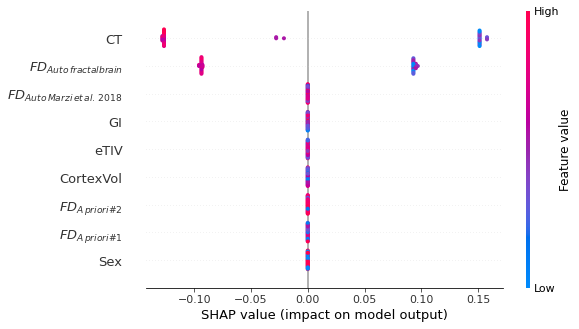

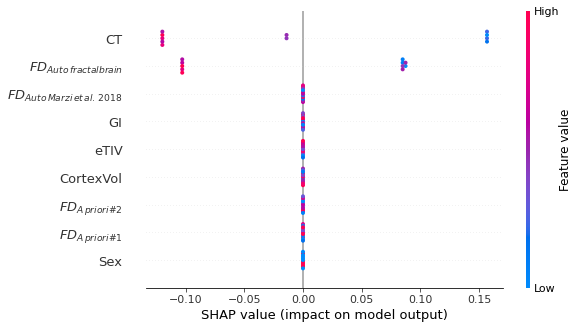

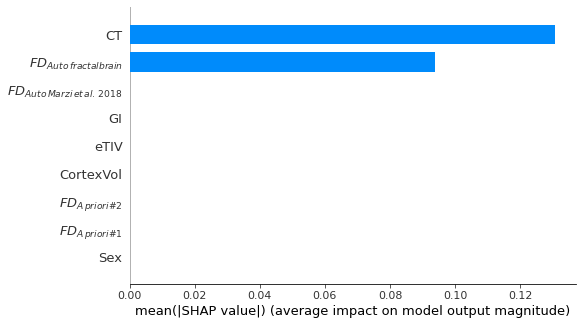

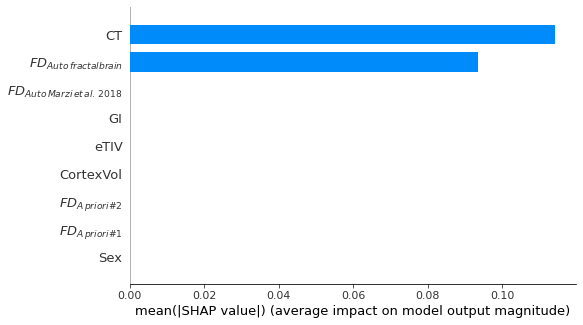

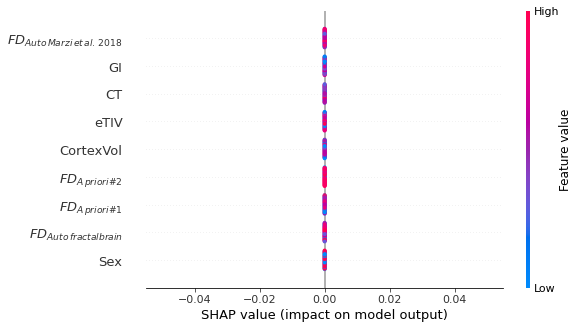

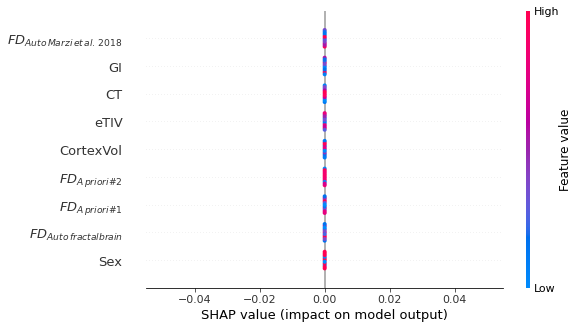

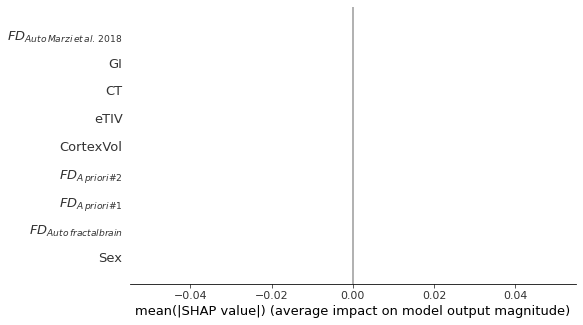

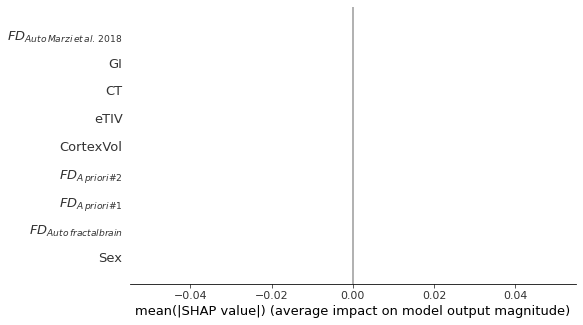

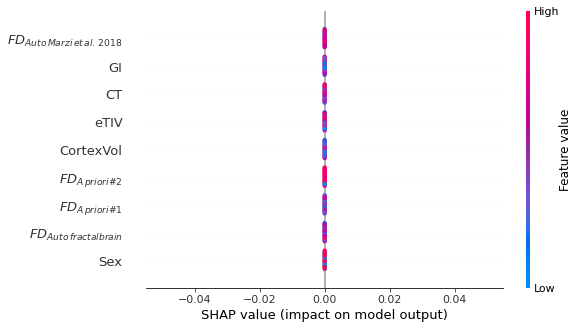

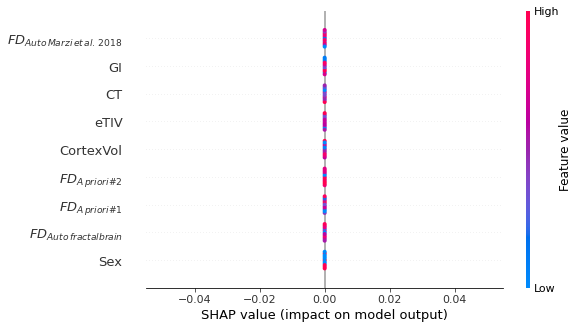

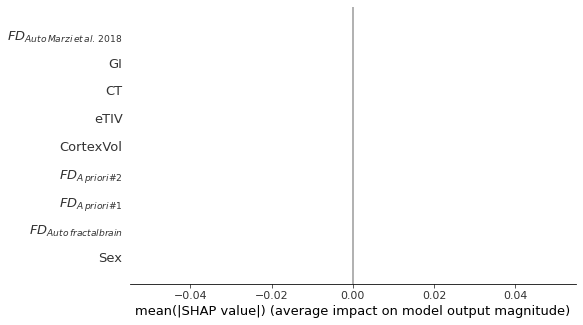

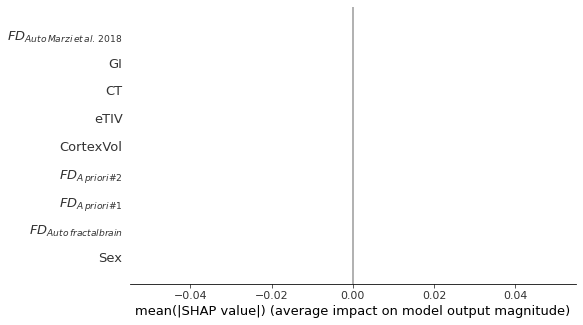

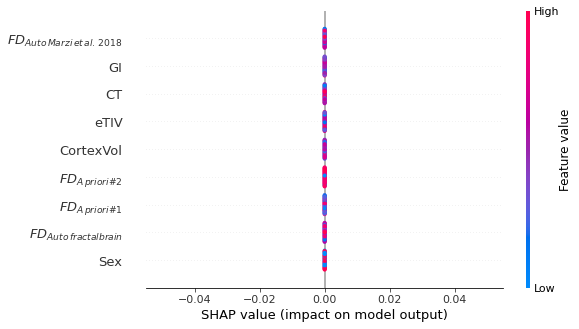

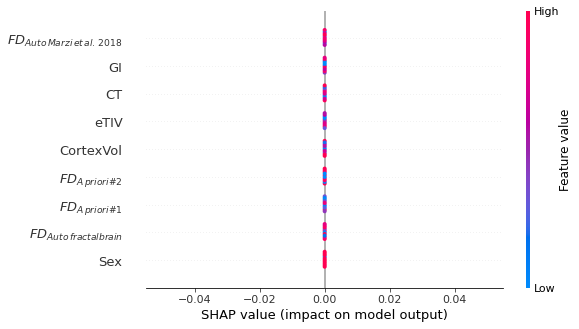

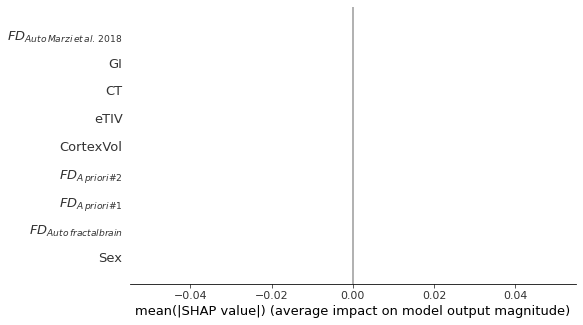

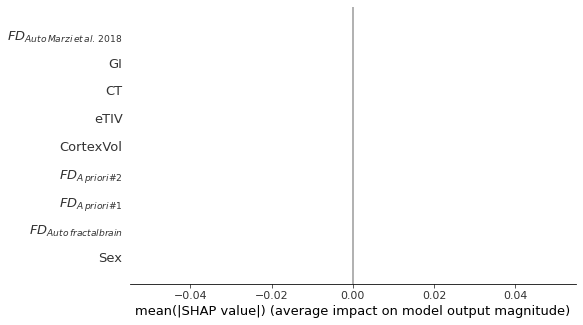

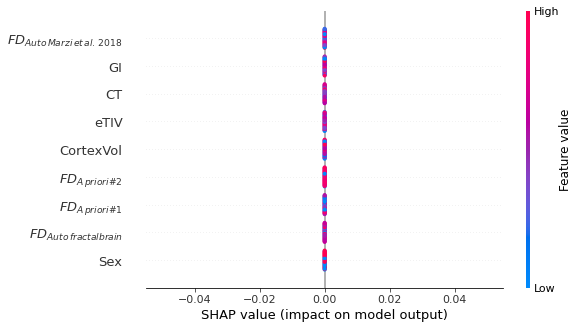

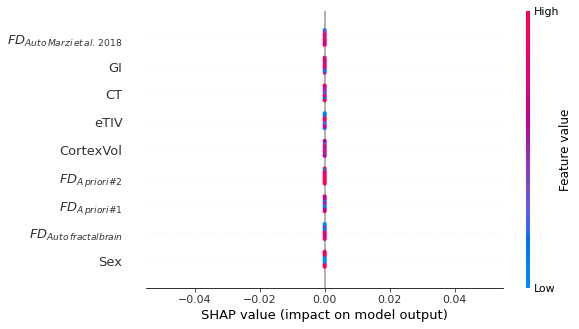

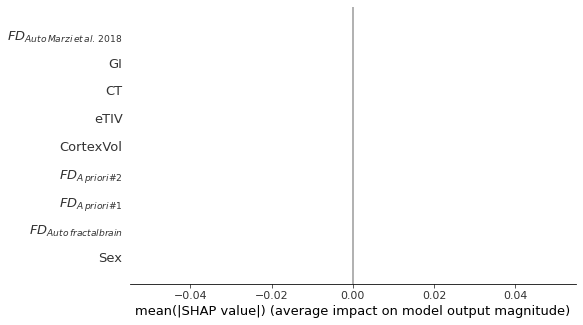

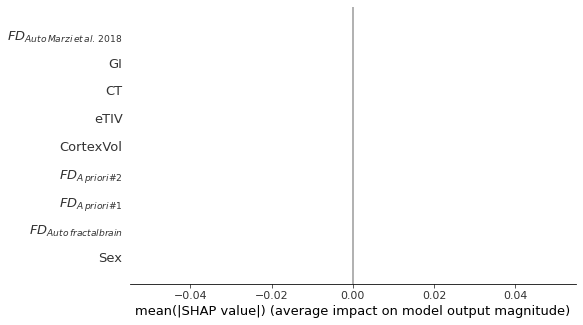

Iteration:1
bal_acc 0.7633333333333334
roc_auc 0.858
ave_pre 0.9017460317460317


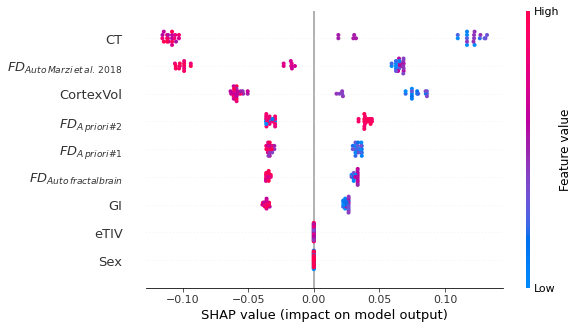

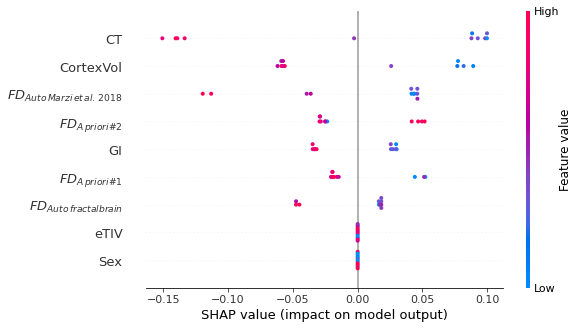

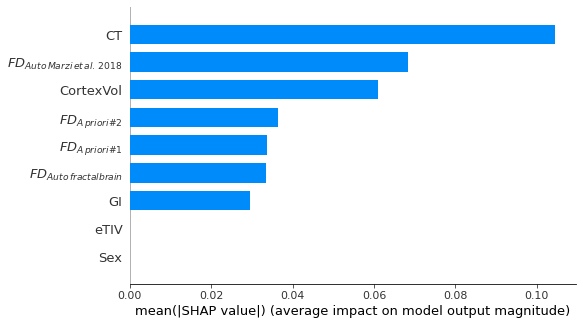

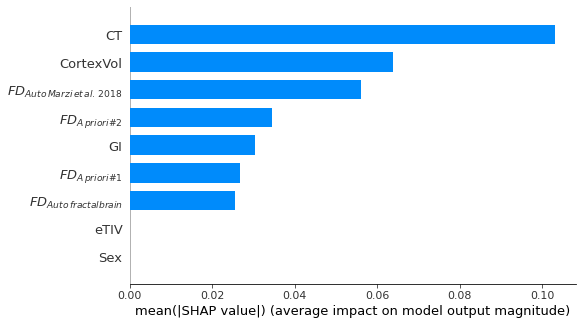

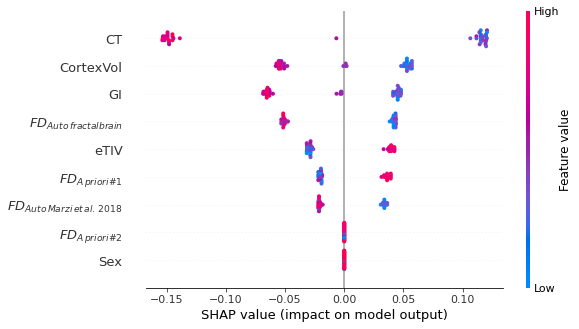

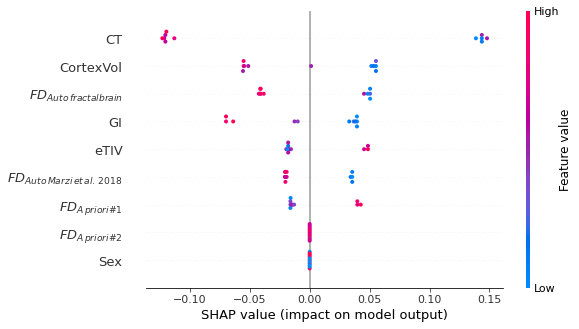

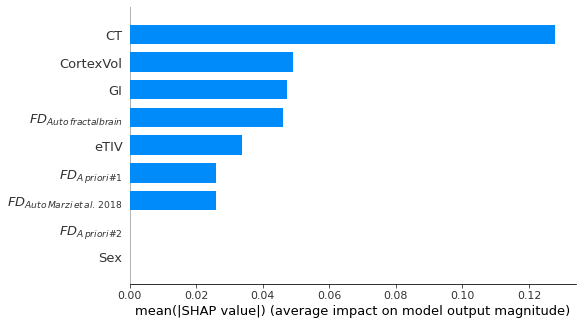

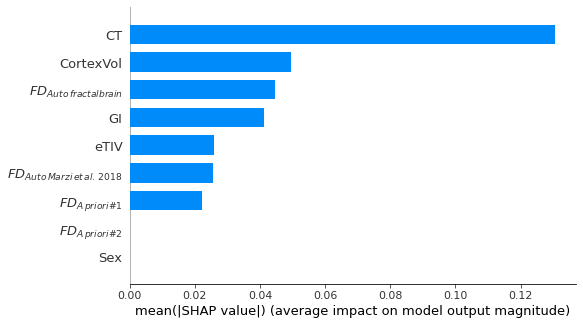

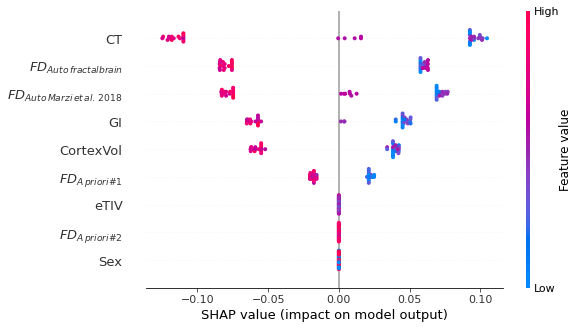

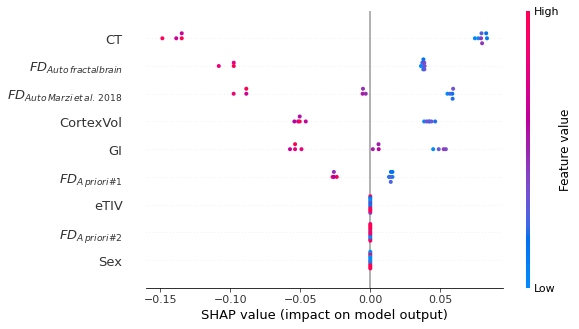

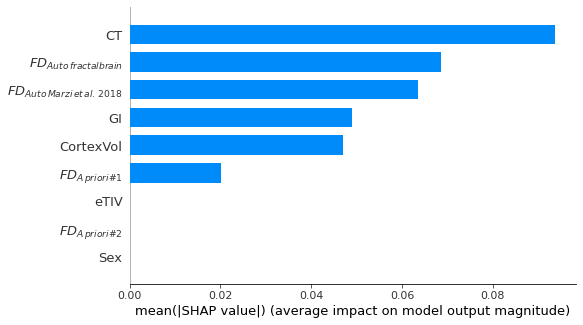

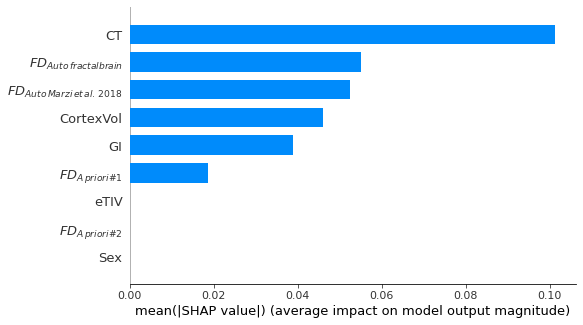

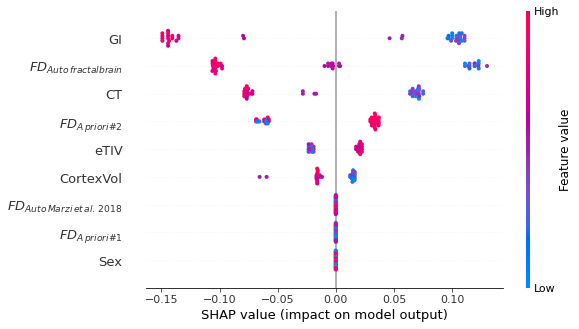

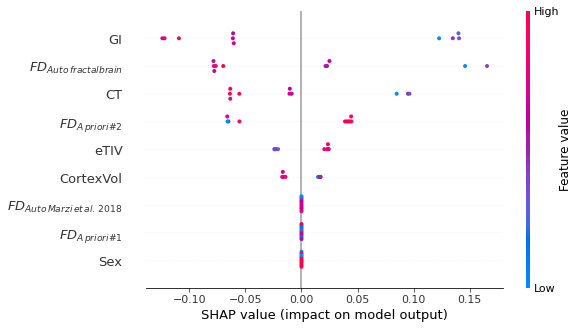

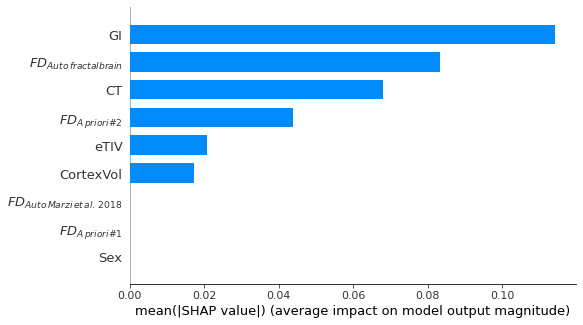

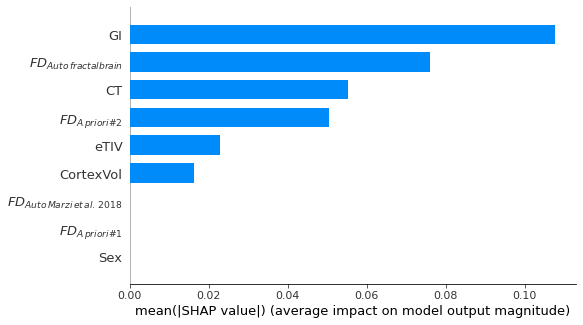

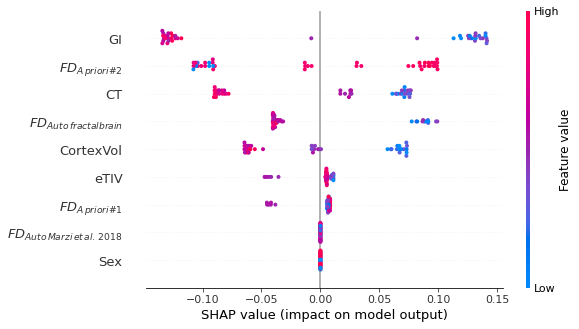

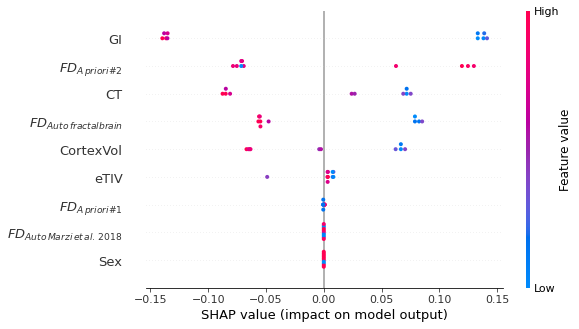

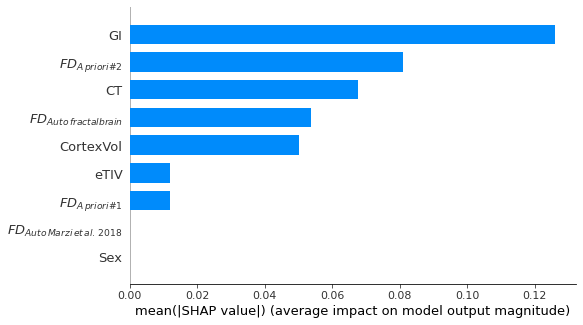

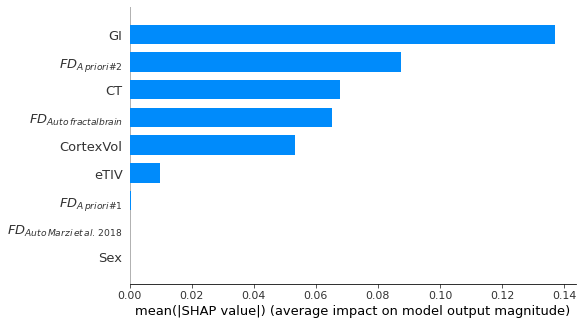

############################## PLOTTING ###################################
Plots saved in classification_ICBM//average_plots/
*** Average performance
test_bal_acc(mean 0.7144565217391304, std 0.13763833992094865)
test_roc_auc(mean 0.7716254940711462, std 0.18208003952569163)
test_ave_pre(mean 0.7872890615976202, std 0.1738762606083199)


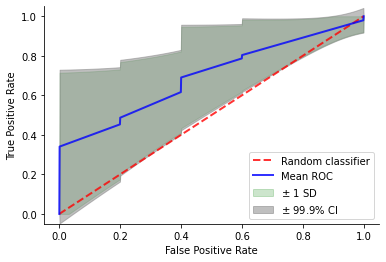

In [36]:

shap.initjs()
for i in range(num_trials):

    print("Iteration:" + str(i))

    inner_cv = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=i)
    outer_cv = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=i)

    pipe = Pipeline(steps=[('imputer', imputer),  ('scaler', scaler), ('classifier', model)])
    clf = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=100, scoring='roc_auc', refit=True, cv=inner_cv, verbose=0,  random_state=i, return_train_score=True)

    # Take a look at the best params
    nested_score = cross_validate(clf, X=X, y=y, cv=outer_cv, return_train_score=True, return_estimator=True, scoring = myscoring)


    bal_acc_train_scores[i] = np.mean(nested_score['train_bal_acc'])
    roc_auc_train_scores[i] = np.mean(nested_score['train_roc_auc'])
    ave_pre_train_scores[i] = np.mean(nested_score['train_ave_pre'])


    bal_acc_test_scores[i] = np.mean(nested_score['test_bal_acc'])
    roc_auc_test_scores[i] = np.mean(nested_score['test_roc_auc'])
    ave_pre_test_scores[i] = np.mean(nested_score['test_ave_pre'])

    print('bal_acc ' + str(bal_acc_test_scores[i]))
    print('roc_auc ' + str(roc_auc_test_scores[i]))
    print('ave_pre ' + str(ave_pre_test_scores[i]))

    auc_dict = {"train_auc": roc_auc_train_scores[i], 
        "test_auc" : roc_auc_test_scores[i]
        }
    df_auc = df_auc.append(auc_dict, ignore_index=True)
    ############# SHAP VALUES COMPUTATION FOR EACH FOLD ##################
    iter_shap = 0
    indices = []

    for train_index, test_index in inner_cv.split(X, y):
        ## TRUE POSITIVE RATE COMPUTATION FOR EACH OUTER LOOP (TEST SET)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = pd.DataFrame(X_train,columns=features)
        X_test = pd.DataFrame(X_test,columns=features)
        y_train = pd.DataFrame(y_train, columns=[target])
        
        pickle.dump(train_index, open(dir_name + '/' + "Shap_values/train_idx_"+str(i)+"_"+str(iter_shap)+".pkl", 'wb'))
        classifier_shap = nested_score['estimator'][iter_shap].best_estimator_["classifier"]

        pipe = Pipeline(steps=[('imputer', imputer),  ('scaler', scaler),('classifier', classifier_shap)])
        pipe.fit(X_train, y_train)

        ##################################  ROC AREA #################
        y_pred = pipe.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        
        ############## SHAP VALUES ################
        model = pipe.named_steps["classifier"]
        ### TRAINING DATA
        train_tmp_df = pd.DataFrame(scaler.fit_transform(imputer.fit_transform(X_train)), columns = features)
        explainer = shap.TreeExplainer(model, train_tmp_df,feature_perturbation='interventional', model_output='probability')
        
        ### TEST DATA
        test_tmp_df = pd.DataFrame(scaler.fit_transform(imputer.fit_transform(X_test)), columns = features)
        test_explainer = shap.TreeExplainer(model, test_tmp_df,feature_perturbation='interventional', model_output='probability')
        #explainer = shap.KernelExplainer(model.predict_proba, tmp_df,feature_perturbation='interventional', model_output='probability')


        #########################################################
        plt.figure()
        shap.summary_plot(explainer.shap_values(train_tmp_df),train_tmp_df, show=False)
        plt.savefig(dir_name + '/plots/train_summary_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png',  bbox_inches = 'tight')
        plt.show()
        plt.close()
        plt.figure()
        shap.summary_plot(test_explainer.shap_values(test_tmp_df),test_tmp_df, show=False)
        plt.savefig(dir_name + '/plots/test_summary_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png', bbox_inches = 'tight')
        plt.show()
        plt.close()

        plt.figure()
        shap.summary_plot(explainer.shap_values(train_tmp_df),train_tmp_df,plot_type="bar", show=False)
        plt.savefig(dir_name +'/plots/train_summary_bar_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png', bbox_inches = 'tight')
        plt.show()
        plt.close()
        plt.figure()
        shap.summary_plot(test_explainer.shap_values(test_tmp_df),test_tmp_df, plot_type="bar",show=False)
        plt.savefig(dir_name +'/plots/test_summary_bar_plot_shap_'+str(i)+'_'+str(iter_shap)+'.png', bbox_inches = 'tight')
        plt.show()
        plt.close()
        #############################################################
 
        df_shap = pd.DataFrame(explainer.shap_values(train_tmp_df),columns=features)
        df_shap["index"] = train_index
        pickle.dump(df_shap, open(dir_name + '/Shap_values/' + 'train'+str(i) + 'fold' + str(iter_shap) + '.pkl','wb'))

        test_df_shap= pd.DataFrame(explainer.shap_values(test_tmp_df),columns=features)
        test_df_shap["index"] = test_index
        pickle.dump(test_df_shap, open(dir_name + '/Shap_values/' + 'test'+str(i) + 'fold' + str(iter_shap) + '.pkl','wb'))
        
        iter_shap += 1
    #######################################################################


df_auc.to_csv(dir_name + "/roc_aucs.csv") 

########################################################################
print("############################## PLOTTING ###################################")
us.roc_plot(mean_fpr,tprs,dir_name,"XGBoost",num_trials,num_splits)
######## PLOTTING PRECISION-RECALL CURVE ##################
print('Plots saved in ' + str(dir_name) + "/average_plots/")
##########################################################

############ RESULTS TABLE ###############################
quantities = {}
quantities_names = ["test_bal_acc","test_roc_auc","test_ave_pre"]
for i, j in zip(quantities_names,[bal_acc_train_scores,roc_auc_train_scores,ave_pre_train_scores,bal_acc_test_scores,roc_auc_test_scores,ave_pre_test_scores]):
    quantities[i] = us.mean_std(j)

print('*** Average performance')

for i in quantities.keys():
    print(i + "(mean " + str(quantities[i][0])+ ", std "+ str(quantities[i][1])+ ")")




# AVERAGE SHAP VALUES FOR TRAIN AND TEST

In [37]:

averaged_shaps = us.average_shap_values(dir_name,data[features], num_trials,num_splits)


## TRAIN SHAP VALUES

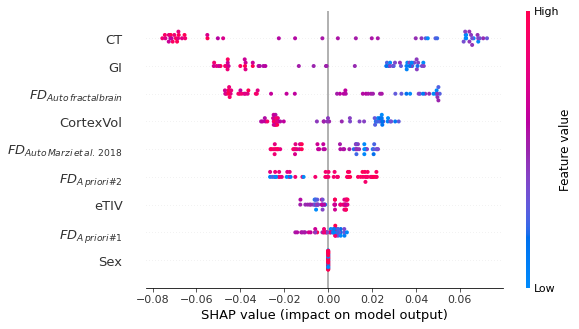

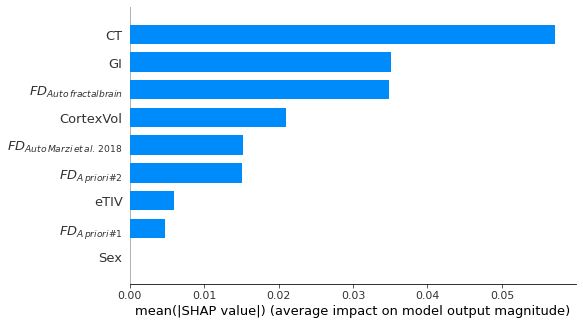

In [38]:
%matplotlib inline

#shap.initjs()
plt.figure()
shap.summary_plot(np.array(averaged_shaps[0]).astype(float),data[features],show=False)
plt.savefig(dir_name + 'average_plots/train.png', dpi = 150, bbox_inches = 'tight')
plt.show()
plt.close()
plt.figure()
shap.summary_plot(np.array(averaged_shaps[0]).astype(float),data[features],plot_type="bar",show=False)
plt.savefig(dir_name + 'average_plots/bar_train.png', dpi = 150, bbox_inches = 'tight')
plt.show()
plt.close()

## TEST SHAP VALUES

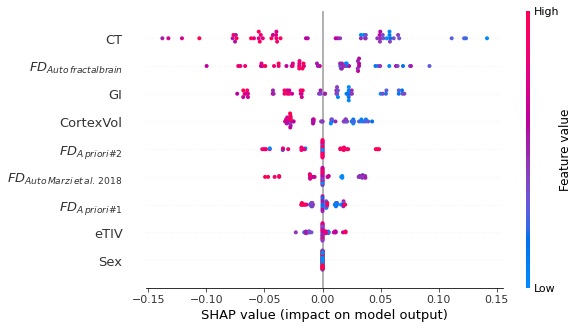

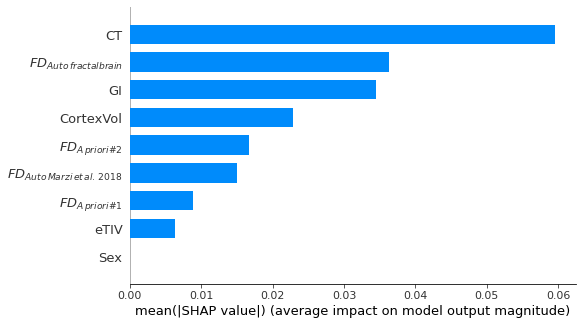

In [39]:
%matplotlib inline

plt.figure()
shap.summary_plot(np.array(averaged_shaps[1]).astype(float),data[features],show=False)
plt.savefig(dir_name + 'average_plots/test.png', dpi = 150, bbox_inches = 'tight')
plt.show()
plt.close()
plt.figure()
shap.summary_plot(np.array(averaged_shaps[1]).astype(float),data[features],plot_type="bar",show=False)
plt.savefig(dir_name + 'average_plots/bar_test.png',dpi = 150, bbox_inches = 'tight')
plt.show()
plt.close()
